In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

# remove warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import merged data without the index column
df = pd.read_csv('merged_df.csv', index_col=None)

## Transform the data
*   Create two datasets one for categorical and another for numerical columns.
*   Usage of the method get_dummies() to convert categorical columns into numerical columns.
*   Concatenation of the two datasets before standardization.
*   Usage of the method StandardScaler() to scale making all the values been between 0 and 1.
*   Usage of method StandardScaler() to scale the numerical columns.

In [3]:
# Making 2 dataframes for categorical and numerical columns
categorical_cols = df.select_dtypes(include=['object', 'category'])
continuous_cols = df[['age', 'absences']]

# remove the targets columns that wont be used for our clustering
categorical_cols = categorical_cols.drop(['absences_range', 'academicGrade'], axis=1)

In [4]:
# Transform categorical columns with the method get_dummies,
# and left out target 'finalresult', 'G1'... and continuous columns also unnecessary columns.
categorical_cols = pd.get_dummies(df[df.columns[~df.columns.isin(['age', 
                                                                  'absences', 'absences_range', 'academicGrade', 'finalResult', 'G1', 'G2', 'G3'])]])

In [5]:
# concatenate categorical and continuous columns
num_scaled = pd.concat([categorical_cols, continuous_cols], axis=1)
# normalize the data
scaler = MinMaxScaler()
df_final = pd.DataFrame(scaler.fit_transform(num_scaled), columns=num_scaled.columns)

For n_clusters = 2 The average silhouette_score is : 0.08097397528929753
For n_clusters = 3 The average silhouette_score is : 0.06219675769792211
For n_clusters = 4 The average silhouette_score is : 0.05422897240108556
For n_clusters = 5 The average silhouette_score is : 0.05388770609472602
For n_clusters = 6 The average silhouette_score is : 0.05471463510089883


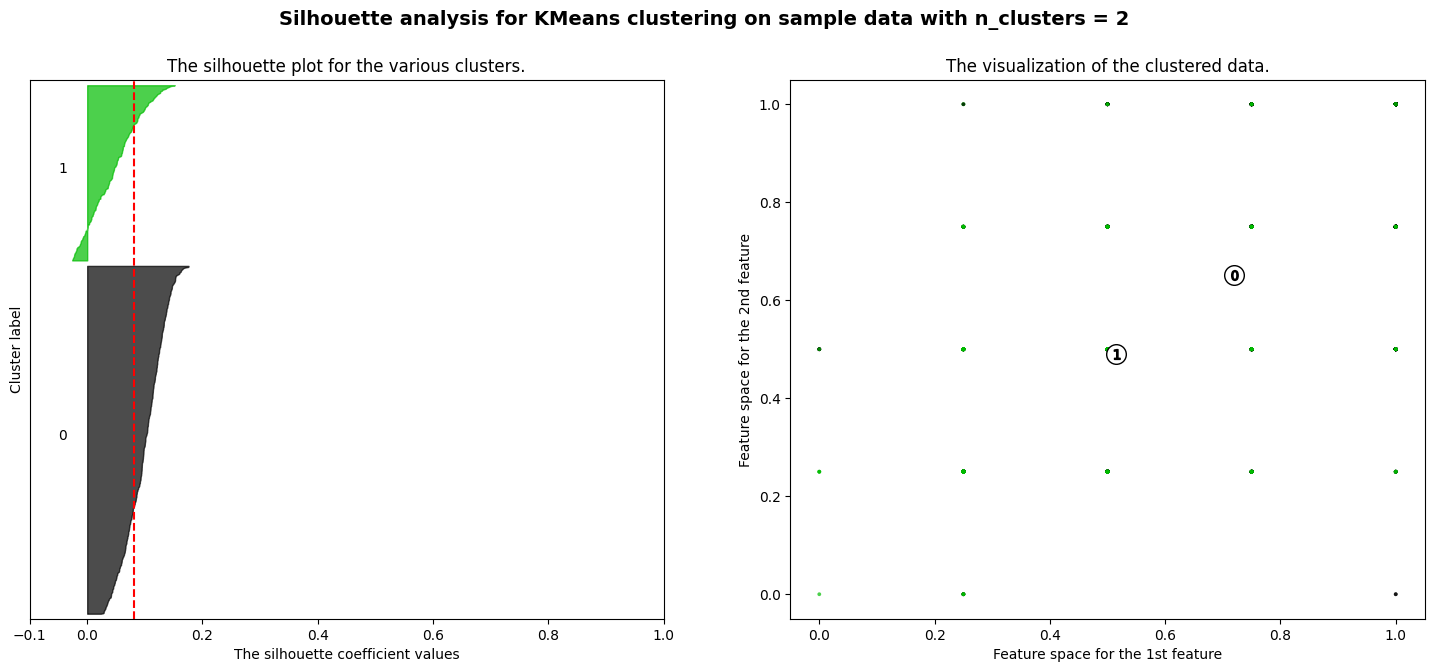

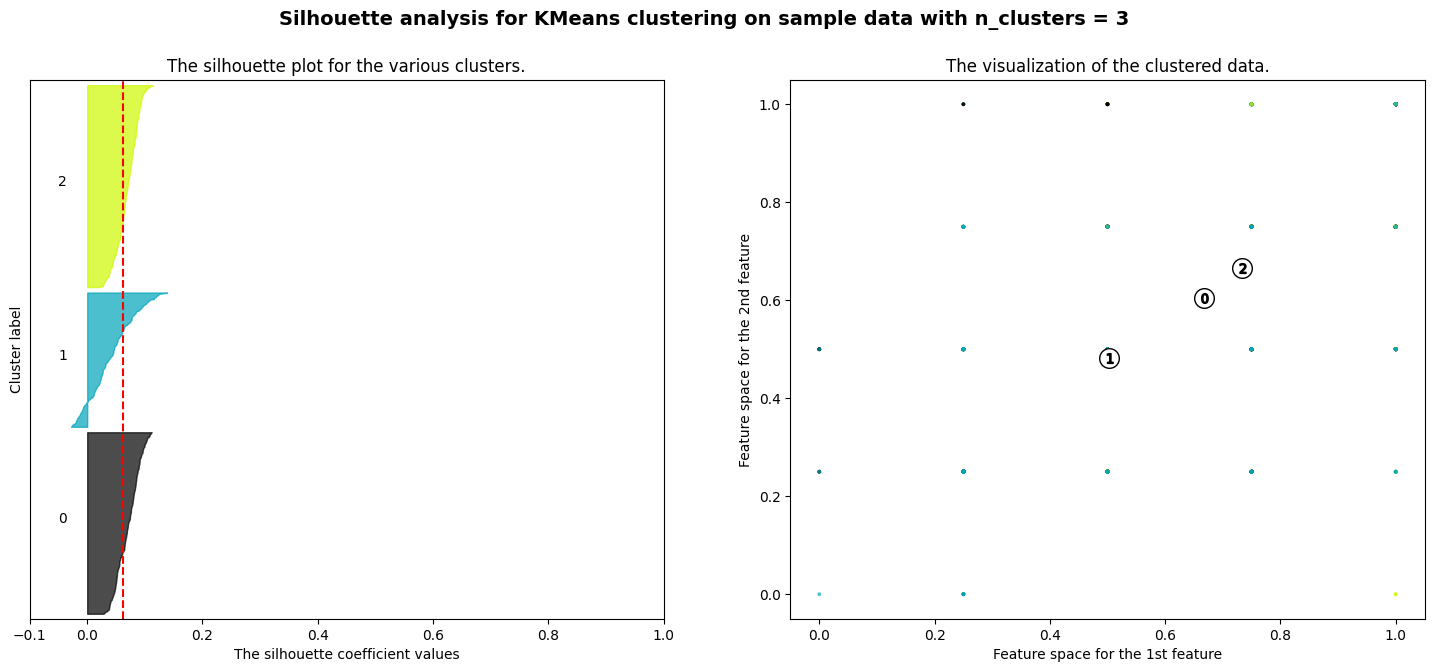

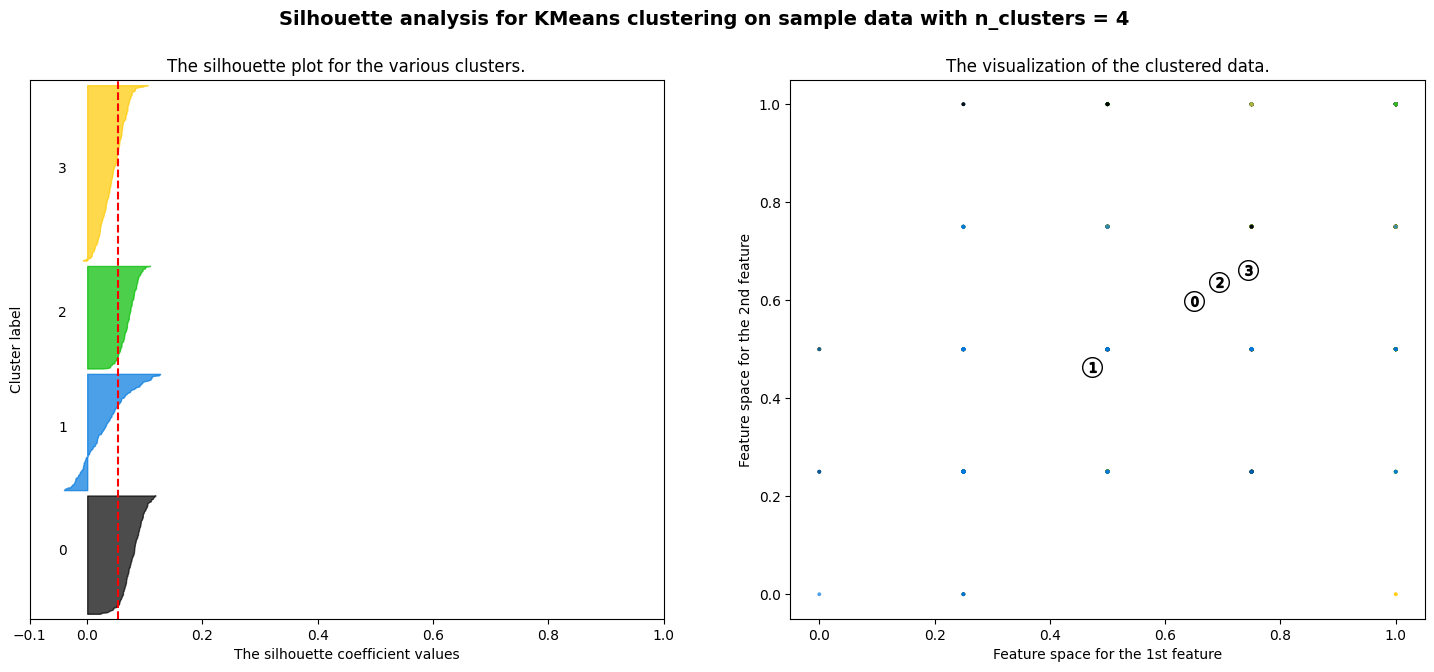

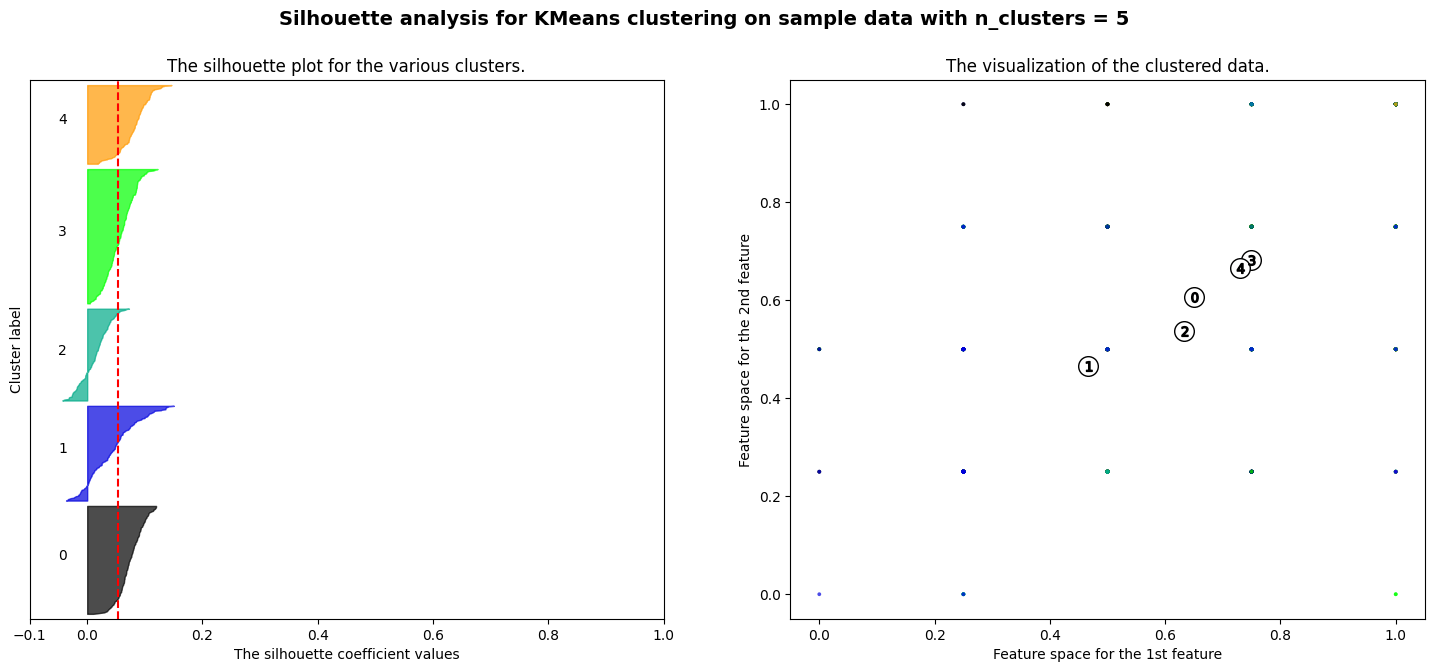

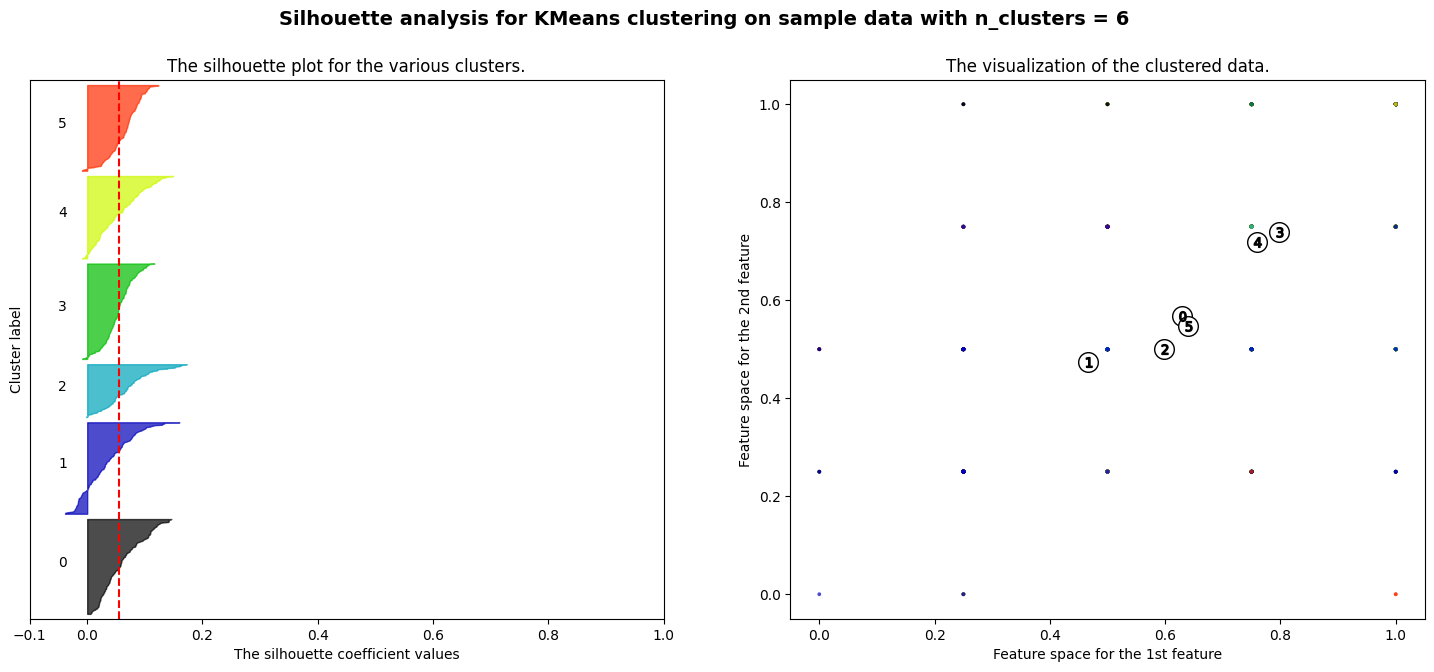

In [6]:
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(df_final) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=10)
    cluster_labels = clusterer.fit_predict(df_final)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(df_final, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_final, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        df_final.iloc[:, 0], df_final.iloc[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

In [7]:
# Instatiate the KMeans algorithm with 2 clusters
n_clusters = 2

clusterer = KMeans(n_clusters=n_clusters, init='k-means++', random_state=10)
cluster_labels = clusterer.fit(df_final)

# Predicting the Clusters
pd.options.display.max_columns = 10
predictions = cluster_labels.labels_
df_final['Clusters'] = predictions
df_final

,Medu,Fedu,traveltime,studytime,failures,...,romantic_no,romantic_yes,age,absences,Clusters
0,1.00,1.00,0.333333,0.333333,0.000000,...,1.0,0.0,0.428571,0.080000,1
1,0.25,0.25,0.000000,0.333333,0.000000,...,1.0,0.0,0.285714,0.053333,1
2,0.25,0.25,0.000000,0.333333,1.000000,...,1.0,0.0,0.000000,0.133333,1
3,1.00,0.50,0.000000,0.666667,0.000000,...,0.0,1.0,0.000000,0.026667,1
4,0.75,0.75,0.000000,0.333333,0.000000,...,1.0,0.0,0.142857,0.053333,1
...,...,...,...,...,...,...,...,...,...,...,...
1039,0.50,0.75,0.000000,0.666667,0.333333,...,1.0,0.0,0.571429,0.053333,1
1040,0.75,0.25,0.000000,0.333333,0.000000,...,1.0,0.0,0.428571,0.053333,1
1041,0.25,0.25,0.333333,0.333333,0.000000,...,1.0,0.0,0.428571,0.080000,1
1042,0.75,0.25,0.333333,0.000000,0.000000,...,1.0,0.0,0.285714,0.080000,0


In [8]:
# Add label column
df_final['finalResult'] = df['finalResult']
# tranform only label column from fail to pass in 0 and 1
df_final['finalResult'] = df_final['finalResult'].apply(lambda x: 0 if x == 'fail' else 1)

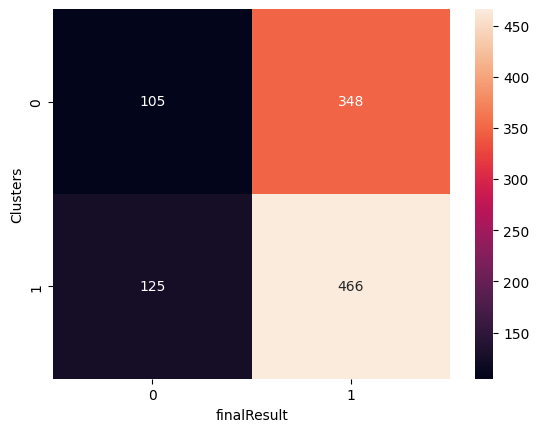

In [9]:
# Analyse Clusters result and finalResult with crosstab 
pd.crosstab(df_final['Clusters'], df_final['finalResult'], margins=True)
# plot confusion matrix
sns.heatmap(pd.crosstab(df_final['Clusters'], df_final['finalResult']), annot=True, fmt='d')
plt.show()


AUC: 0.515


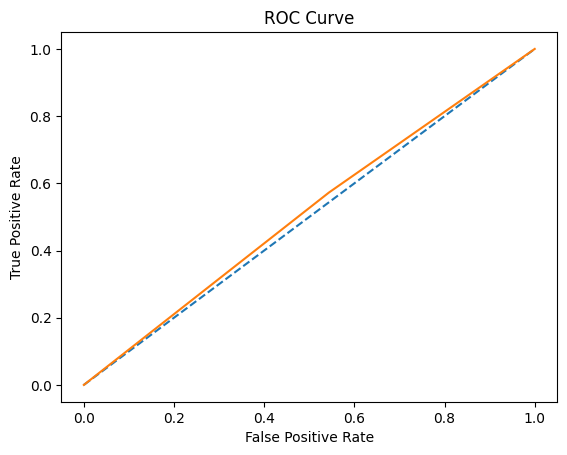

In [10]:
# plot ROC curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

# calculate roc curve
fpr, tpr, thresholds = roc_curve(df_final['finalResult'], df_final['Clusters'])
# calculate AUC
auc = roc_auc_score(df_final['finalResult'], df_final['Clusters'])
print('AUC: %.3f' % auc)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
# show the plot
plt.show()
